# Example notebook continuous calibration

In this notebook, the use of the CP classes for continuous calibration are demonstrated. Note that no 'suitable' dataset is available yet. The dataset used and split is just there to illustrate the workflow, but no results can be interpreted yet

### Import packages and modules

In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [4]:
# Define path to import script(s) from
scripts_path = "../scripts/"
sys.path.append(scripts_path)

In [5]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)

### Define paths and parameters

In [6]:
data_path = "../data/DesFin_pvalues_complete.csv" # File in Tresorit

In [7]:
endpoint = "Toxicity_CHR_Lung_InVivo"

In [8]:
ntrees = 100  # 500
normaliser_model = KNeighborsRegressor()  # None
n_folds_acp = 3  # 20
if normaliser_model:
    ratio_sampler = BalancedStratifiedRatioSampler(n_folds=n_folds_acp)
else:
    ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)

### Load and split data

In [9]:
data = pd.read_csv(data_path, header=0, index_col=0)
print(data.shape)
data = data[data[endpoint] != -1]
print(data.shape)
data.head()

(15608, 2275)
(494, 2275)


,Toxicity_MNT_InVivo,Toxicity_CA_InVivo,Toxicity_Carcinogenicity_InVivo,Toxicity_UDS_InVivo,Toxicity_DILI_Combined_InVivo,Toxicity_Kidney_InVivo,Toxicity_Lung_MolTox_InVivo,Toxicity_MNT_Yoo_InVivo,Toxicity_CHR_Adrenal Gland_InVivo,Toxicity_CHR_Bone Marrow_InVivo,...,p0-CA,p1-CA,p0-UDS,p1-UDS,p0-Caco2,p1-Caco2,p0-PGPinhibition,p1-PGPinhibition,p0-Bioavailability,p1-Bioavailability
14876,-1,-1,1,-1,-1,-1,-1,-1,1,0,...,0.144109,0.342030,0.786943,0.039593,0.019182,0.755698,0.885047,0.005829,0.128986,0.565181
14877,-1,-1,0,-1,-1,-1,-1,-1,0,0,...,0.168492,0.313395,0.248978,0.311875,0.079630,0.439378,0.340913,0.046257,0.101339,0.629551
14878,-1,-1,-1,-1,-1,-1,-1,-1,0,1,...,0.189019,0.259787,0.379967,0.228138,0.268806,0.165307,0.552225,0.024225,0.091047,0.640678
14881,-1,-1,0,-1,-1,-1,-1,-1,1,0,...,0.260047,0.198803,0.898624,0.021212,0.139647,0.312084,0.515495,0.026782,0.083578,0.667163
14883,0,-1,-1,-1,-1,-1,-1,-1,0,0,...,0.413917,0.071498,0.474303,0.176121,0.239218,0.192956,0.118566,0.108153,0.356092,0.260527


In [10]:
# Define labels
y = data[endpoint].values
y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [11]:
# Define features (p-values and chemical descriptors)
columns = [col for col in data.columns if col.startswith('p') or col.startswith('byte')]
X = data[columns].values
X

array([[-0.37348114, -0.12391162, -0.58638527, ...,  0.00582925,
         0.12898623,  0.56518095],
       [-0.41060564,  1.42557556,  1.42087083, ...,  0.04625693,
         0.10133935,  0.62955138],
       [-0.04658185, -0.1036523 ,  4.55488339, ...,  0.02422519,
         0.09104672,  0.64067846],
       ...,
       [-0.37348114,  1.52664848,  0.49044698, ...,  0.06716482,
         0.19273042,  0.44683238],
       [-0.38694121,  0.4449987 , -0.58638527, ...,  0.0075982 ,
         0.07586459,  0.69414705],
       [-0.00567937, -0.1113807 , -0.58638527, ...,  0.00628724,
         0.16703627,  0.49837026]])

In [12]:
# Define individual datasets. Note that this is arbitrary splitting.
# Later we need to define specific datasets
X_train, X_update1, X_update2, X_score = np.split(X, [200, 300, 400])
y_train, y_update1, y_update2, y_score = np.split(y, [200, 300, 400])

In [13]:
# Check len of arrays
print(y_train.shape, X_train.shape)
print(y_update1.shape, X_update1.shape)
print(y_update2.shape, X_update2.shape)
print(y_score.shape, X_score.shape)
# Check if we have actives and inactives in all datasets
print(y_train.sum(), y_update1.sum(), y_update2.sum(), y_score.sum())

(200,) (200, 2078)
(100,) (100, 2078)
(100,) (100, 2078)
(94,) (94, 2078)
73 24 37 32


### Prepare the ACP

In [14]:
clf = RandomForestClassifier(n_estimators=ntrees)
error_function = InverseProbabilityErrFunc()
nc = NcFactory.create_nc(
        clf, err_func=error_function, normalizer_model=normaliser_model
    )
icp = InductiveConformalPredictor(
        nc_function=nc, smoothing=False, condition=(lambda instance: instance[1])
    )  # Mondrian as (default) condition)

In [15]:
acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )

### Fit and calibrate the model, make predictions
Calibrate with the `original` calibration set, which is a split from X_train/y_train

In [16]:
acp.fit_calibrate(X_train=X_train, y_train=y_train)

In [17]:
original_prediction = acp.predict(X_score=X_score)

original_prediction[:5]

array([[0.73913043, 0.43478261],
       [0.7826087 , 0.39130435],
       [0.47826087, 0.30434783],
       [0.95652174, 0.13043478],
       [0.47826087, 0.82608696]])

### Update calibration set
Calibrate the fitted (not yet calibrated) predictors with a 'new' dataset

In [18]:
# Check that no `calibrated update` predictor yet
print(acp.predictors_calibrated_update)

{}


In [19]:
acp.calibrate_update(X_update=X_update1, y_update=y_update1)

final n:  1


1

In [20]:
# Make predictions with the model and the updated calibration set
calibrate_update_prediction = acp.predict_calibrate_update(updated_number=1, X_score=X_score)
calibrate_update_prediction[:5]

updated_number:  1


array([[0.75324675, 0.28      ],
       [0.81818182, 0.28      ],
       [0.32467532, 0.28      ],
       [0.93506494, 0.12      ],
       [0.32467532, 0.84      ]])

### New calibration
We can update with an even 'newer' calibration set (as often as we want). The model with the updated calibration set will be saved in the acp object.

In [21]:
# Check how many updated calibration sets we already have. Here, this should be 1
print(acp.predictors_calibrated_update.keys())

dict_keys(['update_1'])


In [22]:
acp.calibrate_update(X_update=X_update2, y_update=y_update2)

n 1
final n:  2


2

In [23]:
calibrate_update_2_predcition = acp.predict_calibrate_update(updated_number=2, X_score=X_score)
calibrate_update_2_predcition[:5]

updated_number:  2


array([[0.703125  , 0.28947368],
       [0.796875  , 0.23684211],
       [0.28125   , 0.28947368],
       [0.921875  , 0.07894737],
       [0.28125   , 0.71052632]])

### Perform continuous calibration within crossvalidation
Instead of using the individual acp's, we might want to include everything into a crossvalidator. 
Advantages: 
* Splitting of cv into test and train set are handled
* Fixed and reproducible pipeline (except for random splitting and random forest)
* We can automatically create a calibration plot
* Updating of the same trained models possible

Note that we use fivefold cv by default

In [24]:
cv_acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )
cross_validator = CrossValidator(predictor=cv_acp, cv_splitter=CrossValidationSampler())

In [25]:
# Crossvalidate with the "original" training set (no update calibration set)
cv_eval_df = cross_validator.cross_validate(X_train=X_train, y_train=y_train, X_score=X_score, y_score=y_score, steps=10, endpoint=endpoint)

fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


In [26]:
# Look at evaluation per cv fold
cv_eval_df[["validity", "efficiency", "accuracy", "significance_level", "fold"]].set_index("fold").head()

,validity,efficiency,accuracy,significance_level
fold,,,,
0,1.000,0.000,0.000,0.0
0,0.975,0.025,0.000,0.1
0,0.900,0.175,0.429,0.2
0,0.875,0.275,0.545,0.3
0,0.800,0.450,0.556,0.4


In [27]:
# Look at averaged (all folds) evaluations
cross_validator.averaged_evaluation_df_cv[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.000,0.000,0.0000,0.0
0.1,0.980,0.040,0.5000,0.1
0.2,0.890,0.175,0.4042,0.2
0.3,0.790,0.360,0.4404,0.3
0.4,0.660,0.565,0.4692,0.4
0.5,0.530,0.690,0.4390,0.5
0.6,0.420,0.680,0.4640,0.6
0.7,0.275,0.515,0.4968,0.7
0.8,0.155,0.300,0.4934,0.8


The predictions are saved in a dictionary that contains the information for the predictions within the crossvalidation and the predictions for the score set. The predictions (values) are in the form of a list, list elements are the predicted p-values and the known labels. 

In [28]:
print("keys: ", cross_validator._predictions.keys(), "\n")
print("p-values: ", cross_validator._predictions["pred_score"][0][0][:5], "\n")
# [0]: predictions, [0]: first loop of cv, [:5]: first five p-values
print("labels: ", cross_validator._predictions["pred_score"][1])
# [1]: labels

keys:  dict_keys(['cv', 'pred_score']) 

p-values:  [[0.21052632 1.        ]
 [0.68421053 0.89473684]
 [0.78947368 0.26315789]
 [0.84210526 0.73684211]
 [0.36842105 0.89473684]] 

labels:  [1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [29]:
# Look at evaluation df for cross validation (averaged over all folds)
cross_validator.averaged_evaluation_df_cv

,validity mean,validity std,validity_0 mean,validity_0 std,validity_1 mean,validity_1 std,error_rate mean,error_rate std,error_rate_0 mean,error_rate_0 std,...,efficiency_1 std,accuracy mean,accuracy std,accuracy_0 mean,accuracy_0 std,accuracy_1 mean,accuracy_1 std,significance_level,num_actives,num_inactives
significance_level,,,,,,,,,,,,,,,,,,,,,
0.0,1.000,0.000000,1.0000,0.000000,1.0000,0.000000,0.000,0.000000,0.0000,0.000000,...,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0,73,127
0.1,0.980,0.020917,0.9840,0.021909,0.9724,0.037819,0.020,0.020917,0.0160,0.021909,...,0.047062,0.5000,0.500000,0.2000,0.447214,0.4000,0.547723,0.1,73,127
0.2,0.890,0.054772,0.8970,0.082735,0.8742,0.106413,0.110,0.054772,0.1030,0.082735,...,0.065989,0.4042,0.216891,0.4572,0.366277,0.3666,0.415003,0.2,73,127
0.3,0.790,0.100933,0.7782,0.161886,0.8076,0.077174,0.210,0.100933,0.2218,0.161886,...,0.109166,0.4404,0.105453,0.4672,0.230715,0.4524,0.139086,0.3,73,127
0.4,0.660,0.100933,0.6828,0.144488,0.6172,0.023552,0.340,0.100933,0.3172,0.144488,...,0.125849,0.4692,0.098839,0.4944,0.152787,0.4216,0.109674,0.4,73,127
0.5,0.530,0.020917,0.5350,0.037577,0.5200,0.071169,0.470,0.020917,0.4650,0.037577,...,0.105376,0.4390,0.048831,0.4264,0.100209,0.4516,0.133979,0.5,73,127
0.6,0.420,0.057009,0.4646,0.051145,0.3448,0.116515,0.580,0.057009,0.5354,0.051145,...,0.049788,0.4640,0.064827,0.4894,0.066010,0.4110,0.134015,0.6,73,127
0.7,0.275,0.091856,0.3222,0.091007,0.1922,0.099943,0.725,0.091856,0.6778,0.091007,...,0.098010,0.4968,0.113810,0.5390,0.128614,0.4072,0.127707,0.7,73,127
0.8,0.155,0.067082,0.1812,0.106446,0.1094,0.037132,0.845,0.067082,0.8188,0.106446,...,0.094172,0.4934,0.125506,0.5022,0.217178,0.5500,0.273861,0.8,73,127


In [42]:
# Look at evaluation df predicting the score set (averaged over all folds)
cross_validator.averaged_evaluation_df_pred_score[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9912,0.0130,0.3000,0.1
0.2,0.9128,0.1384,0.3576,0.2
0.3,0.8490,0.2810,0.4738,0.3
0.4,0.7360,0.5040,0.5100,0.4
0.5,0.6320,0.6148,0.4886,0.5
0.6,0.4660,0.6704,0.5226,0.6
0.7,0.2828,0.5298,0.5078,0.7
0.8,0.1596,0.3554,0.4542,0.8


### Calibration plots of CV and prediction of score set, using the 'original' calibration set
Note that we can not interpret these plots as results yet as the underlying data is based on just an arbitrary split of one dataset.

The plot shows the mean (line) and standard deviation (area) of the evaluation measures indicated in the legend (expected_error_rate excluded) over the fivefold crossvalidation. 

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/kter-py38/lib/python3.8/site-packages/matplotlib/pyplot.py'>

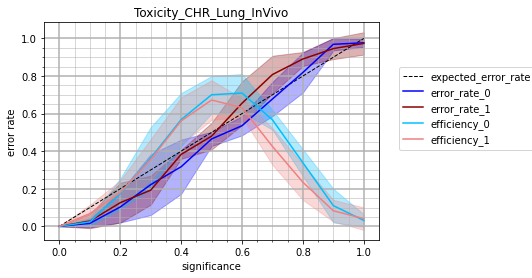

In [30]:
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv)

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/kter-py38/lib/python3.8/site-packages/matplotlib/pyplot.py'>

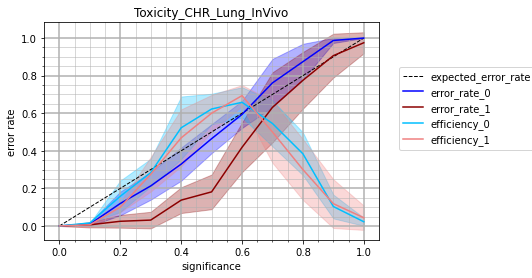

In [31]:
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_score)

In [32]:
# We would get an assertion error, if we try to plot the calibration plot using the updated calibration set, 
# since we have not updated it yet.
# cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update_1)

In [33]:
print(len(cross_validator.train_indices[0]))

160


### Update the calibration set within the crossvalidator
Note: here we show the first update step with X_update1/y_update1. We could add one more update step with X_update2/y_update2.

In [34]:
# For control, the 'updated number' is printed, which is the number under which the updated 
# model/predictions are saved. This is important since the number will be incremented
# automatically when another number is already used.
cross_validator.cross_validate_calibrate_update(X_update=X_update1, y_update=y_update1, X_score=X_score, y_score=y_score, steps=10, endpoint=endpoint)

fold:  0
final n:  1
updated_number:  1
fold:  1
final n:  1
updated_number:  1
fold:  2
final n:  1
updated_number:  1
fold:  3
final n:  1
updated_number:  1
fold:  4
final n:  1
updated_number:  1


In [35]:
cross_validator._evaluation_dfs.keys()

dict_keys(['cv', 'pred_score', 'cal_update_1'])

In [36]:
cross_validator._predictions.keys()

dict_keys(['cv', 'pred_score', 'cal_update_1'])

In [37]:
print(len(cross_validator.predictors))

5


In [43]:
# Look at evaluation df predicting the score set using the updated calibration set (averaged over all folds)
cross_validator.averaged_evaluation_df_cal_update_1[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9552,0.0702,0.4688,0.1
0.2,0.9126,0.1660,0.4950,0.2
0.3,0.8128,0.3660,0.5048,0.3
0.4,0.7148,0.5088,0.4944,0.4
0.5,0.5446,0.6658,0.4858,0.5
0.6,0.3978,0.6810,0.4698,0.6
0.7,0.2874,0.5702,0.4642,0.7
0.8,0.2024,0.4044,0.4948,0.8


In [ ]:
# Look at evaluation df for cross validation (averaged over all folds)
cross_validator.avera

### Calibration plot for the score set using the updated calibration set

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/kter-py38/lib/python3.8/site-packages/matplotlib/pyplot.py'>

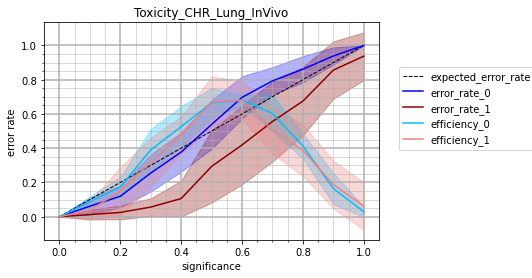

In [38]:
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update_1)